
## Lets Undertand the Update Rule<br/>

![assets](1.png)


In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(3, 4))
    def forward(self, state):
        action_vals = self.fc1(state)
        return action_vals

<font size = 4>Recall that π<sub>θ</sub>(a|s) is the probability of doing an action a give a state s.

So ∇<sub>θ</sub>π<sub>θ</sub>(a|s) must indicate the direction to change θ such that this value is maximised.

Let a' be the best action given s,  which means that π<sub>θ</sub>(a'|s) must be as close to 1 as possible and for any other action it should return 0. So lets use the update rule to make this happen<br/>
So the update equation now looks like<br/><br/>
    
![](assets/2.png)

So lets see this in action with a dummy example<br/>
Suppose I have 4 actions (0,1,2,3) and given my current state, action 1 is the best possible action.
Lets write a bit of code</font>

<IPython.core.display.Javascript object>


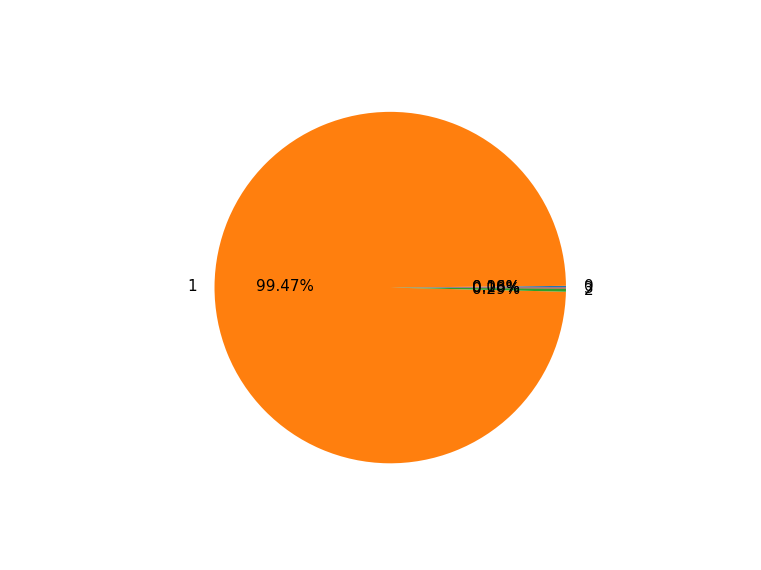

In [3]:
torch.manual_seed(0)
state = torch.rand(1,3) # some meaningless state
lr = 0.1
net = Policy()

def update():
    net.zero_grad()
    action_vals = net(state)
    #compute grads
    best_action = action_vals[:,1]
    best_action.backward()
    #update params
    for f in net.parameters():
        f.data.copy_(f.data + lr*f.grad)
        
figure, ax = plt.subplots()

def piechart(num):
    ax.clear()
    ax.axis('equal')
    action = F.softmax(net(state))[0].tolist()
    labels = [0,1,2,3]
    ax.pie(x = action, labels = labels, autopct='%1.2f%%')
    update()

anim = animation.FuncAnimation(figure, piechart, frames = range(30), repeat = False)
plt.show()

<font size = 4>So as you saw we were able to maximize the probability of action 1. But in reality we do not know the best action. So we need a measure to tell us if a doing a certain action at a given state is good or not. Can you think of anything?

So the simplest answer is to check the total reward accumulated after carrying out that action. If this reward is high that means this action was good else it was bad. Now of course this is not the best way to measure the goodness, put it works for now. This total reward it called G<sub>t</sub>.

Now assume that we have been given the values of G<sub>t</sub> for each action. So we will use these values to push the probabilites of the actions by different values. If an action has a higher G<sub>t</sub>, it's probability will be pushed more than the others.<br/>
So now the update equation looks like <br/><br/> 
    
![](assets/3.png)

Alright then lets see this happen!!</font>

<IPython.core.display.Javascript object>


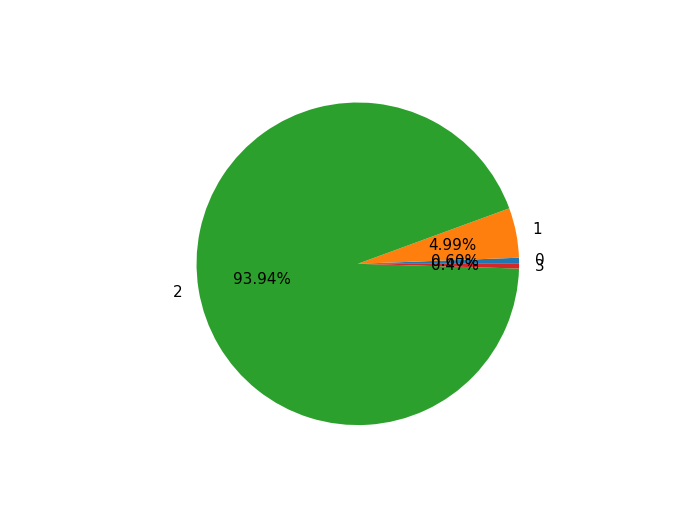

In [4]:
import random
torch.manual_seed(0)
state = torch.rand(1,3) # some meaningless state
random.seed(0)
lr = 0.01
Gt = [10, 25, 30, 9]
net = Policy()
def update():
    #choose a random action
    action_choice = random.choice([0,1,2,3])
    net.zero_grad()
    action = net(state)[:,action_choice]
    #compute grads
    action.backward()
    #update params
    for f in net.parameters():
        f.data.copy_(f.data + lr*Gt[action_choice]*f.grad)
plt.close('all')      
figure, ax = plt.subplots()
anim = animation.FuncAnimation(figure, piechart, frames = range(30), repeat = False)
plt.show()

<font size = 4>Ahh! It went as expected. Since we got the G<sub>t</sub> of action 2 to be the highest that action dominated finally. 

But, we have not yet reached our equation. Saw you saw above, we chose an action randomly and then updated its value. But that is not what is actually happening. Actions that return higher probability have more chance of being chosen, because after all, the policy tells us the action.

So what you ask? If a bad action initially had a high chance of being chosen - which is possible as the network is not trained, it will end up being trained on more. So even though it had a less G<sub>t</sub>, it will be pushed more number of times than the actual good action and could turn out dominating.

Lets see this happen. For this the only change is instead of choosing an action randomly, we will choose it based on the probability values returned by the policy</font>

In [5]:
#Lets do a bad initialization on purpose
import numpy as np
torch.manual_seed(0)
state = torch.rand(1,3) # some meaningless state
np.random.seed(1)
net = Policy()
Gt = [10,25,30,9]

probabs = F.softmax(net(state)[0]).tolist()
print(f'Probabilities : {probabs}')
print(f'Gt : {Gt}')

Probabilities : [0.16953006386756897, 0.4238332211971283, 0.31664666533470154, 0.0899900496006012]
Gt : [10, 25, 30, 9]


<font size = 4>We see that it is initialized such that action 1 has higher probability but the G<sub>t</sub> values say that action 2 is the best action. Now lets see what happens</font>

<IPython.core.display.Javascript object>


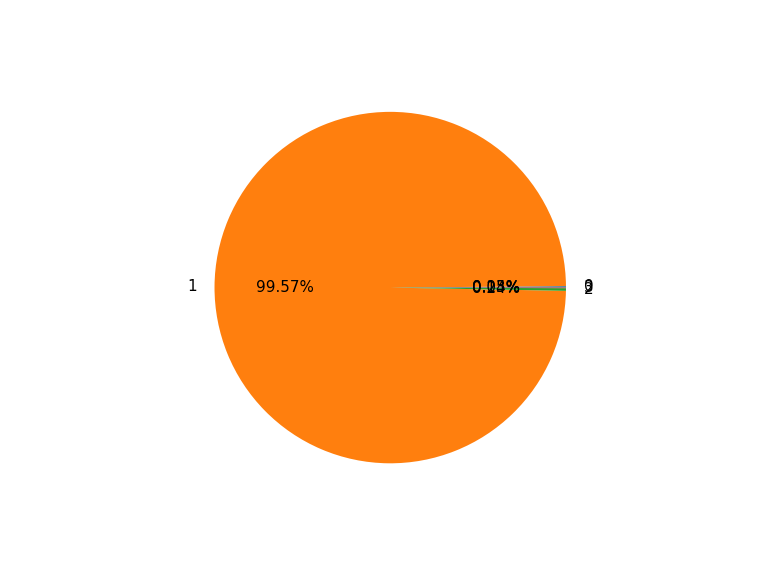

In [9]:
import numpy as np
torch.manual_seed(0)
state = torch.rand(1,3) # some meaningless state
np.random.seed(1)
net = Policy()
Gt = [10,25,30,9]
lr = 0.005
def update():
    #choose a random action
    pi = F.softmax(net(state))[0].tolist()
    pi = [round(a,2) for a in pi]
    pi[3] = round(1- pi[0] - pi[1] - pi[2],2)
    net.zero_grad()
    action_vals = net(state)
    action_choice = np.random.choice([0,1,2,3], p = pi)
    action = action_vals[:,action_choice]
    #compute grads
    action.backward()
    #update params
    for f in net.parameters():
        f.data.copy_(f.data + lr*Gt[action_choice]*f.grad)
    
plt.close('all')     
figure, ax = plt.subplots()
anim = animation.FuncAnimation(figure, piechart, frames = range(30), repeat = False)
plt.show()

<font size = 4>As we see, even though action 1 had a lower return, because of its higher probability of sampling, it ended up being the dominating action.

So whats the solution to this? Simple, to compensate for the higher rate of sampling, we divide out update with the probability of the action. So if a bad action had a higher probability of sampling, dividing it decreases the amount of push we are giving to that action to a certain amount

So now our update equation is:<br/></font><br/><br/> 

![](assets/4.png)

<font size = 4>Lets verify if this fixes things</font>

<IPython.core.display.Javascript object>


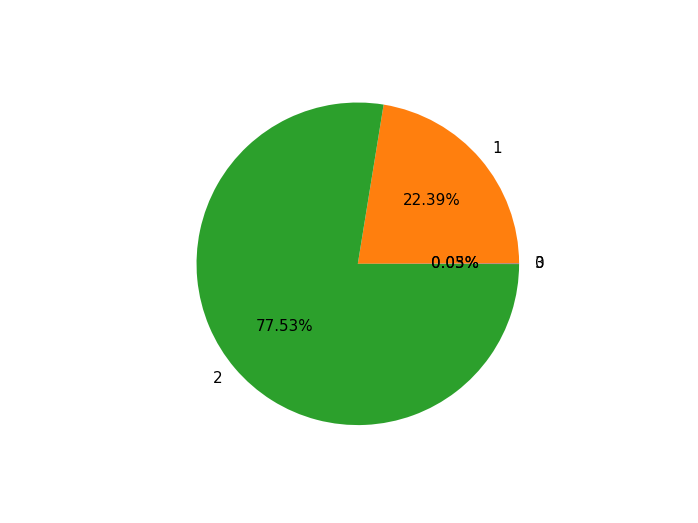

In [10]:
import numpy as np
torch.manual_seed(0)
state = torch.rand(1,3) # some meaningless state
np.random.seed(0)
net = Policy()
Gt = [10,25,30,9]
lr = 0.003
def update():
    #global pi
    pi = F.softmax(net(state))[0].tolist()
    pi = [round(a,2) for a in pi]
    pi[3] = round(1- pi[0] - pi[1] - pi[2],2)
    
    net.zero_grad()
    action_vals = net(state)
    action_choice = np.random.choice([0,1,2,3], p = pi)
    action = action_vals[:,action_choice]
    #compute grads
    action.backward()
    #update params
    for f in net.parameters():
        f.data.copy_(f.data + lr*Gt[action_choice]*f.grad/pi[action_choice])
    
        
plt.close('all')     
figure, ax = plt.subplots()
anim = animation.FuncAnimation(figure, piechart, frames = range(30), repeat = False)
plt.show()

<font size = 4>Great, it works, and we have reached the end of this.<br/>
Now If you look at our final update equation <br/><br/></font>

![](assets/5.png)

<font size = 4>So now we can write our initial update rule that we started with</font><br/><br/> 

![](assets/1.png)